## **ML Part**

In [1]:
import matplotlib.pyplot as plt
import numpy as np 

import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch 
from math import pi

import scipy.signal as signal

from tqdm.auto import tqdm
import pandas as pd
torch.manual_seed(44)
from torchmetrics import R2Score


In [3]:
!nvidia-smi

Mon Feb 27 23:30:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0    14W /  N/A |    368MiB /  4096MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,params,transform=None):

        if len(params['DATA_PATH'])!=0:
          self.df = self.read_transform_df(params['DATA_PATH'],params['SEQUENCE_LENGTH'])
        
        else:
          self.df = params['DF']

        if  params['SNR'] !=-1:
          df = pd.DataFrame(columns=self.df.columns)
          for snr in params['SNR']:
            temp = self.df.loc[self.df['all_snr'] == snr]
            df = temp.append(df)

          self.df = df

      

        self.sequence_length = params['SEQUENCE_LENGTH']
        self.inputs = np.clip(self.df['all_y_SD'].values, -np.sqrt(R), np.sqrt(R)).astype(np.float32)
        self.received = self.df['all_y_SD'].values.astype(np.float32)
        #self.inputs = self.inputs/np.std(self.inputs)
        try:
          self.labels = self.df['all_MAP'].values.astype(np.float32)
        except:
          self.labels = np.zeros_like(self.inputs)
          
        self.len = len(self.inputs)//self.sequence_length


    # Get the length
    def __len__(self):
        return self.len 
    
    # Getter
    def __getitem__(self, index):

          input = torch.tensor(self.inputs[index * self.sequence_length : (index+1)*self.sequence_length]).type(torch.Tensor).view(self.sequence_length)
          label = torch.tensor(self.labels[index * self.sequence_length : (index+1)*self.sequence_length]).type(torch.Tensor)
          return input,label

    def split_data(self):
      val_size = params['VALIDATION_AND_TEST_SET_SIZE']
      return torch.utils.data.random_split(self,[self.len - 2 *int(self.len*val_size),  int(self.len*val_size),  int(self.len*val_size)])

    def read_transform_df(self,path,seq_len):
      df = pd.read_csv(path)
      #for i in range(1,seq_len):
      #  df['y_SD-'+str(i)] = df['y_SD'].shift(i)
      #df = df[seq_len:]
      #df.reset_index(drop=True, inplace=True)
      return df


In [14]:
 
class Experiment:
 
    def __init__(self,model=None):
        self.device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.use_cuda = torch.cuda.is_available()
        self.model = model.to(self.device)
        self.optimizer = None
        self.scheduler = None
        self.criterion = torch.nn.MSELoss()#L1Loss(reduction='sum').cuda() if self.use_cuda else torch.nn.L1Loss(reduction='sum')
        self.train_losses = []
        self.val_losses = []
        self.val_R2_scores = []
        self.start_epoch = 1
 
    def train(self,train_data_loader,
              val_data_loader,
              save_dir,
              model_name,
              num_epochs=75, 
              batch_size=64, 
              learning_rate=0.001,
              validate_each_epoch=False,
              verbose=False):
       
 
        self.model.train()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=4, verbose=True)
        pbar = tqdm(range(self.start_epoch, num_epochs + 1))
        self.r2score = R2Score().to(self.device)

        for epoch in pbar:
 
 
            epoch_losses = []
            i = 0
 
            for i, data in enumerate(train_data_loader, 1):
 
                noisy_signals, denoised_signals = data
                noisy_signals = noisy_signals.to(self.device)
                
                denoised_signals =denoised_signals.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model.forward(noisy_signals)
                
                loss = self.criterion(outputs, denoised_signals)

                loss.backward()
 
                self.optimizer.step()
 
            
                epoch_losses.append(loss.data.cpu())
                
                self.start_epoch = epoch
                
            self.train_losses.append(np.mean(epoch_losses))
 
 
 
            if validate_each_epoch:
                val_loss,val_R2_score= self.test(val_data_loader)
                self.val_losses.append(val_loss)
                self.val_R2_scores.append(val_R2_score)
                if verbose:
                  pbar.set_postfix({"  Train loss ":np.mean(epoch_losses),' Val loss ':val_loss,' Val R2 ':val_R2_score})
            
            self.scheduler.step(np.mean(epoch_losses))
            
    def predict(self,data_loader):
        """Tests the network.
 
        """
        
        self.model.eval()
        
        inputs = []
        labels = []
        predictions = []
 
        with torch.no_grad():
            for data in data_loader:
                noisy_signals, denoised_signals = data
                noisy_signals = noisy_signals.to(self.device)
                denoised_signals = denoised_signals.to(self.device)
 
                outputs = self.model.forward(noisy_signals).view(-1).cpu().numpy()
                predictions.extend(list(outputs))
                labels.extend(list(denoised_signals.view(-1).cpu().numpy()))
                inputs.extend(list(noisy_signals.view(-1).cpu().numpy()))
 
        self.model.train()
        return predictions,inputs,labels

    def test(self,data_loader, batch_size=64):
        """Tests the network.
 
        """
        
        self.model.eval()
        
        epoch_losses = []
        epoch_R2_scores = []
 
        with torch.no_grad():
            for data in data_loader:
                noisy_signals, denoised_signals = data
                noisy_signals = noisy_signals.to(self.device)
                denoised_signals = denoised_signals.to(self.device) 
                outputs = self.model.forward(noisy_signals)
 
                loss = self.criterion(outputs, denoised_signals)
                epoch_losses.append(loss.data.cpu())
                epoch_R2_scores.append(self.r2score(outputs.view(-1), denoised_signals.view(-1)).cpu().numpy())

        self.model.train()
        return np.mean(epoch_losses), np.mean(epoch_R2_scores)
 
    def save_parameters(self,model_name, directory):
        """Saves the parameters of the network to the specified directory.
 
        Parameters
        ----------
        epoch : int
            The current epoch
        directory : str
            The directory to which the parameters will be saved
        """
        if not os.path.exists(directory):
            os.makedirs(directory)
        torch.save({
            'epoch': self.start_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }, os.path.join(directory, model_name +'.pth'))
 
    def load_parameters(self, path):
        """Loads the given set of parameters.
 
        Parameters
        ----------
        path : str
            The file path pointing to the file containing the parameters
        """
        self.optimizer = torch.optim.Adam(self.model.parameters())
        checkpoint = torch.load(path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        self.start_epoch = checkpoint['epoch']
 
 
def bpsk_to_bit(bpsk):
  ## -1 to 1 and 1 to 0
  bits = (bpsk <= 0).type(torch.float)
  return bits
 
def binary(probs):
  ## >0.5 to 1 and <0.5 to 0
  bits = (probs >= 0.5 ).type(torch.float)
  return bits



In [23]:
torch.set_num_threads(1)

In [24]:



class BNET(nn.Module):
  def __init__(self, seq_len,backbone = '',aug_factor = 5):
    super(BNET, self).__init__()
    aug_factor = 5
    self.backbone = True
    self.seq_len = seq_len
    self.fc1  =  nn.Sequential(
        nn.Linear(seq_len* aug_factor, seq_len*aug_factor),
        nn.LeakyReLU(),
        )

    if backbone == 'GRU':
      self.backbone_layer = nn.GRU(input_size =1,
                        hidden_size=aug_factor,
                        num_layers = 1,
                        batch_first=True)
    elif backbone == 'RNN':
      self.backbone_layer = nn.RNN(input_size =1,
                        hidden_size=aug_factor,
                        num_layers = 1,
                        batch_first=True)

    elif backbone == 'LSTM':
      self.backbone_layer = nn.LSTM(input_size =1,
                        hidden_size=aug_factor,
                        num_layers = 1,
                        batch_first=True)
    else :
      self.backbone = False
      self.fc1  =  nn.Sequential(
        nn.Linear(seq_len, seq_len*aug_factor),
        nn.LeakyReLU())

    self.fc2_prob_symbol_0  =  nn.Linear(seq_len*aug_factor, seq_len)
    self.fc2_prob_symbol_1  =  nn.Linear(seq_len*aug_factor, seq_len)

  def forward(self, x):

    if self.backbone :
      x = x.view(x.shape[0],x.shape[1],1)
      x ,_= self.backbone_layer(x)
    

    x = x.reshape((x.shape[0],-1))
    x = self.fc1(x)
    prob_symbol_0 = torch.sigmoid(self.fc2_prob_symbol_0(x))
    prob_symbol_1 = torch.sigmoid(self.fc2_prob_symbol_1(x))

    LLR = torch.log(prob_symbol_0/(prob_symbol_1)) 

    return LLR 





In [25]:
params = {}
params['SEQUENCE_LENGTH'] = 32# or 64 or 128
params['SNR']   = -1

R     = 50
GAMMA = 20
Tc = 32
P_B = 0.5

ExecutionTimeCalculation = []

params['DATA_PATH'] = "train datasets/Tc = "+str(Tc)+", pb = " +str(P_B)+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ".csv"
#params['DATA_PATH'] = "train datasets/COMBINED pb = 0.3.csv"
params['VALIDATION_AND_TEST_SET_SIZE'] = 0.1

dataset =Dataset(params)
train_dataset ,val_dataset, test_dataset  = dataset.split_data()
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 62500)
validation_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=1024)

model =  BNET(seq_len = params['SEQUENCE_LENGTH'],backbone = 'GRU')
exp = Experiment(model)

for param in exp.model.parameters():
    param.requires_grad = True

In [ ]:
exp.train(train_data_loader=train_loader,
          val_data_loader=validation_loader,
          save_dir="",
          model_name = '',
          num_epochs=600,
          learning_rate=0.001,  
          validate_each_epoch=True,
          verbose=True)

In [306]:
PATH = "BNET + LSTM"
exp.save_parameters(PATH,'./models R50 G100/')


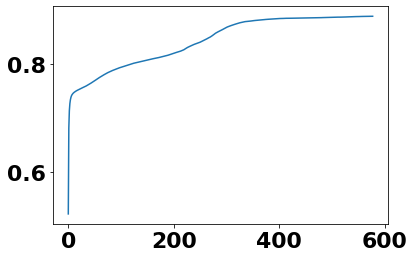

In [297]:
plt.plot(exp.val_R2_scores)

In [26]:
#np.save('METRICS/BNET VAL MSE VARIATION DURING TRAINING.npy',exp.val_losses)
#np.save('METRICS/BNET VAL R2 VARIATION DURING TRAINING.npy',exp.val_R2_scores)

In [296]:
print('Average Exec Time = ',np.mean(ExecutionTimeCalculation[2:]) )

Average Exec Time =  0.00014577901029261525


### MSE and R2 plots

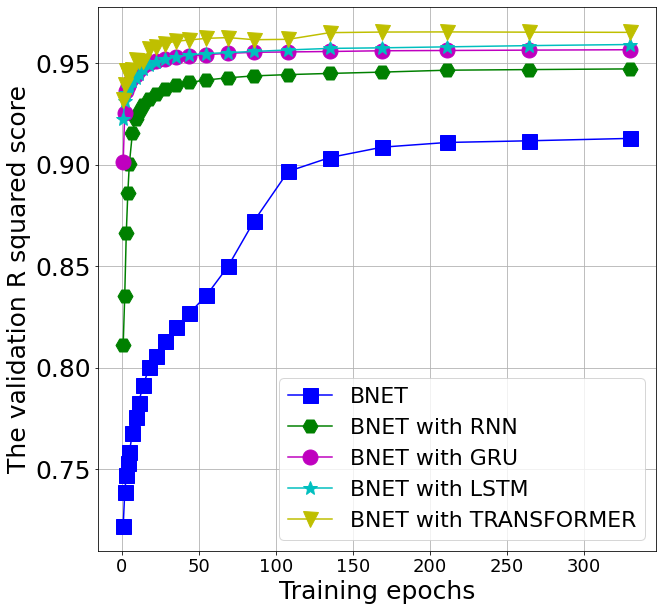

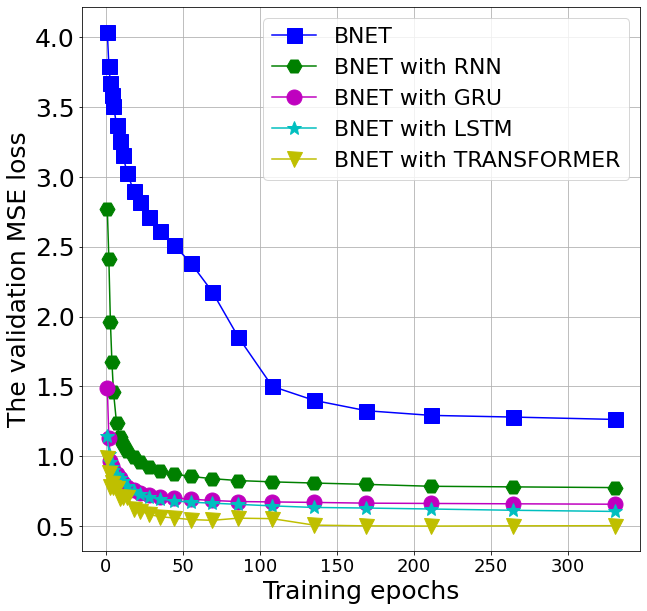

In [27]:

# Program to display the Fibonacci sequence up to n-th term
indexes = np.sort(list(set([int((1.25)**x) for x in range(27)])))
[indexes] 

val_R2_log = pd.DataFrame()
val_R2_log['BNET'] = np.load('METRICS/BNET VAL R2 VARIATION DURING TRAINING.npy')[indexes]
val_R2_log['BNET with RNN'] = np.load('METRICS/BNET RNN VAL R2 VARIATION DURING TRAINING.npy')[indexes]
val_R2_log['BNET with GRU'] = np.load('METRICS/BNET GRU VAL R2 VARIATION DURING TRAINING.npy')[indexes]
val_R2_log['BNET with LSTM'] = np.load('METRICS/BNET LSTM VAL R2 VARIATION DURING TRAINING.npy')[indexes]
val_R2_log['BNET with TRANSFORMER'] = np.load('METRICS/BNET TRANSFORMER VAL R2 VARIATION DURING TRAINING.npy')[indexes]


markers = ["s","H","o","*","v","X","<",">","1","2","3","4","8","s","p","P","*","h",".","x","o","v","H","<",">","1","2","3","4","8","s","p","P","*","h"]
colors = ['b','g', 'm','c','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k']
fig, ax = plt.subplots(nrows=1,ncols = 1,figsize=(10,10))
j = 0

for column in val_R2_log.columns:

      ax.plot(indexes,val_R2_log[column],color= colors[j],marker=markers[j],linestyle='solid',label=column,markersize=15)
      j+=1


  
ax.set_xlabel('Training epochs',fontsize=25)
ax.set_ylabel('The validation R squared score',fontsize=25)
#ax.set_title('Probability of Bit Error for BPSK over TSMG channel with LDPC',fontsize=15)
ax.grid(True)
ax.legend(fontsize=22)
plt.xticks(size = 18)
plt.yticks(size = 25)
plt.show()



val_MSE_log = pd.DataFrame()
val_MSE_log['BNET'] = np.load('METRICS/BNET VAL MSE VARIATION DURING TRAINING.npy')[indexes]
val_MSE_log['BNET with RNN'] = np.load('METRICS/BNET RNN VAL MSE VARIATION DURING TRAINING.npy')[indexes]
val_MSE_log['BNET with GRU'] = np.load('METRICS/BNET GRU VAL MSE VARIATION DURING TRAINING.npy')[indexes]
val_MSE_log['BNET with LSTM'] = np.load('METRICS/BNET LSTM VAL MSE VARIATION DURING TRAINING.npy')[indexes]
val_MSE_log['BNET with TRANSFORMER'] = np.load('METRICS/BNET TRANSFORMER VAL MSE VARIATION DURING TRAINING.npy')[indexes]


markers = ["s","H","o","*","v","X","<",">","1","2","3","4","8","s","p","P","*","h",".","x","o","v","H","<",">","1","2","3","4","8","s","p","P","*","h"]
colors = ['b','g', 'm','c','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k']
fig, ax = plt.subplots(nrows=1,ncols = 1,figsize=(10,10))
j = 0

for column in val_MSE_log.columns:

        
      ax.plot(indexes,val_MSE_log[column],color= colors[j],marker=markers[j],linestyle='solid',label=column,markersize=15)
      j+=1


  
ax.set_xlabel('Training epochs',fontsize=25)
ax.set_ylabel('The validation MSE loss',fontsize=25)
#ax.set_title('Probability of Bit Error for BPSK over TSMG channel with LDPC',fontsize=15)
ax.grid(True)
ax.legend(fontsize=22)
plt.xticks(size = 18)
plt.yticks(size = 25)
plt.show()

In [250]:
params = {}
params['SEQUENCE_LENGTH'] = 32# or 64 or 128
params['SNR']   = -1

R     = 20
GAMMA = 100
Tc = 32
P_B = 0.5

params['DATA_PATH'] = "train datasets/Tc = "+str(Tc)+", pb = " +str(P_B)+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ".csv"
params['VALIDATION_AND_TEST_SET_SIZE'] = 0.1

dataset =Dataset(params)


backbone_string = " + GRU"

MSE = "0.7"
params = {}
params['SEQUENCE_LENGTH'] = 32

FOLDER = "test datasets/G"+str(GAMMA)+"_R"+str(R)+'/'

model = BNET(seq_len = params['SEQUENCE_LENGTH'],backbone='GRU')
exp = Experiment(model)
exp.load_parameters("models/BNET"+backbone_string+".pth")#+", seq_len = "+str(params['SEQUENCE_LENGTH'])+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", MSE = "+MSE+".pth")


In [ ]:
index = 500
size = 32*3
transmitted = dataset.df["all_x"][index:index+size].values
received = dataset.received[index:index+size]
input = dataset.inputs[index:index+size]
label = dataset.labels[index:index+size]
output = exp.model(torch.Tensor(input).cuda().view(-1,32)).view(-1).cpu().detach().numpy()

from matplotlib import rc, rcParams

rcParams.update({'font.size': 22})
rc('font', weight='bold')

fig=plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax2.plot(output, label = "LLR output by BNET with GRU", linestyle="-",linewidth=3.0)
ax2.plot(label, label = "LLR output by BCJR", linestyle="-",linewidth=3.0)

ax1.plot(transmitted, label = "Original BPSK signal", linestyle="-",linewidth=3.0)
ax1.plot(received, label = "Received Noisy Signal", linestyle="-",linewidth=3.0)


ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
# ax2.autoscale() ## call autoscale if needed
ax1.legend()
ax2.legend()


ax2.set_ylabel('Amplitude', weight='bold')
ax1.set_ylabel('Amplitude', weight='bold')
plt.xlabel('timesteps', weight='bold')

plt.show()

## Test Part

In [ ]:

R     = 50
GAMMA = 100
P_B = 0.1
backbone_string = " + LSTM"

params = {}
params['SEQUENCE_LENGTH'] = 32

FOLDER = "test datasets/G"+str(GAMMA)+"_R"+str(R)+'/'

model = BNET(seq_len = params['SEQUENCE_LENGTH'],backbone='LSTM')
exp = Experiment(model)

for param in exp.model.parameters():
    param.requires_grad = True

exp.load_parameters("/home/hazem/Desktop/BNET V1/models R50 G100/BNET"+backbone_string+".pth")#+", seq_len = "+str(params['SEQUENCE_LENGTH'])+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", MSE = "+MSE+".pth")

test = pd.DataFrame(columns=['snr','R','gamma','p_B', 'MAP_BCJR', 'Received', 'MAP_BNET'])
snr_db  = [0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,7,8,9,10]
snr_db  = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8]
snr_db  = [4,4.5,5,5.5,6]

for snr in tqdm(snr_db):
                params['SNR']   = [snr]
                params['DATA_PATH'] = ''
                df = pd.read_csv(FOLDER+str(snr)+"received.csv")
                params['DF'] = df
                dataset_test =Dataset(params)

                test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=512)
                MAP_hat, _ ,_= exp.predict(test_loader)

                temp_df =pd.DataFrame(columns=['snr', 'MAP_BCJR', 'Received', 'MAP_BNET'])
                temp_df['snr'] = [snr for i in range(len(MAP_hat))]

                temp_df['MAP_BCJR'] = dataset_test.df['all_MAP'].values.copy()
                temp_df['Received'] = dataset_test.df['all_y_SD'].values.copy()
                temp_df['MAP_BNET'] = MAP_hat
                del dataset_test
                temp_df.round(3).to_csv(FOLDER+str(snr)+" predictions BNET"+backbone_string+".csv",index=False)
                del temp_df
                del df
                import gc
                gc.collect()

#test.to_csv("test datasets/predictions BNET"+backbone_string+", seq_len = "+str(params['SEQUENCE_LENGTH'])+ ", gamma = "+str(GAMMA)+", R = "+str(R)+ ", p_B = "+str(P_B)+".csv",index=False)

## Plot BER

In [13]:

from scipy.special import erfc #erfc/Q function
from random import choices
import numpy as np
from math import pi
import scipy.signal as signal
import math
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
 

from matplotlib import rc, rcParams

rcParams.update({'font.size': 22})
rc('font', weight='bold')


def plot_BERs(path_BNET, others):

      results_BNET =  pd.read_csv(path_BNET)
      results_others = []
      for path in others:
        try:
          results_others.append(pd.read_csv(path))
        except:
          break

      markers = ["s","H","o","*","v","X","p",">","1","2","3","4","8","s","p","P","*","h",".","x","o","v","H","<",">","1","2","3","4","8","s","p","P","*","h"]
      colors = ['k','b','g','r', 'm','c','y','k','orangered','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k','b','g', 'c','m','y','k']
      fig, ax = plt.subplots(nrows=1,ncols = 1,figsize=(10,7))
      j = 0

      for column in results_BNET.columns:
        EbN0dBs = results_BNET['snr_s'].values
        BER = results_BNET[column].values
        if column == 'BER_BCJRs':
          label = "BCJR"
        elif column == 'BER_BNETs':
          label = "BNET"
        elif column in ['snr_s', 'BER_Nothing_s'] :
          continue
        else:
          label = column
        
        #BER = BER[BER >  9.10e-6]
        ax.semilogy(EbN0dBs[:len(BER)],BER,color= colors[j],marker=markers[j],linestyle='solid',label=label,markersize=15)
        j+=1

      for id in range(len(results_others)): 

        for column in results_others[id].columns:
          BER =  results_others[id][column].values[:len(BER)]
          #EbN0dBs = results_BNET_GRU['snr_s'].values
          if column == 'BER_BNETs':
            labels = ["BNET with GRU","BNET with LSTM","BNET with RNN","BNET with TRANSFORMER"]
            label = labels[id]
          #elif column == 'AWGN_Channel':
          #  label = "AWGN Channel"
          elif column == 'AWGN_Receiver':
            label = "Gaussian Receiver"
          elif column == 'blanking':
              label = "Blanking with fixed Tb = 3.4"
          elif column == 'clipping':
            label = "clipping with fixed Tc = 0.9"
          elif column == 'cliping_blanking':
            label = "clipping and blanking, \n Tb=3.4 and Tc=0.9"
          elif column in ['BER_BCJRs','snr_s', 'BER_Nothing_s','snr_db','BCJR','AWGN_Channel'] :
            continue
          else:
            label = column
          ax.semilogy(EbN0dBs[:len(BER)],BER,color= colors[j],marker=markers[j],linestyle='solid',label=label,markersize=15)
          j+=1


        
        #BER = BER[BER !=0]



      ax.set_xlabel('$E_b/N_0(dB)$',fontsize=25)
      ax.set_ylabel('BER ($P_b$)',fontsize=25)
      #ax.set_title('Probability of Bit Error for BPSK over TSMG channel with LDPC',fontsize=15)
      ax.grid(True) 
      plt.legend(loc="upper right", prop={'size': 15})
      plt.xticks(size = 18)
      plt.yticks(size = 25)
      ax.set_ylim([0.000009, 0.3])
      ax.set_xlim([0.25, 8])
      plt.legend(loc='upper right',prop={'size':14})

      plt.show()







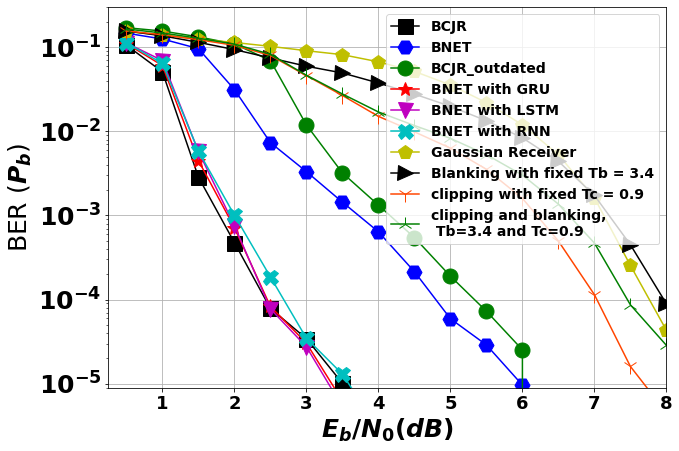

In [17]:

R     = 20
GAMMA = 50
P_B = 0.1
folder   = "results 2/"
PATH_BNET = folder+'BNET, gamma = '+str(GAMMA)+', R = '+str(R)+', p_B = '+str(P_B)+'.csv'
PATH_BNET_GRU = folder+'BNET + GRU, gamma = '+str(GAMMA)+', R = '+str(R)+', p_B = '+str(P_B)+'.csv'
PATH_BNET_LSTM = folder+'BNET + LSTM, gamma = '+str(GAMMA)+', R = '+str(R)+', p_B = '+str(P_B)+'.csv'
PATH_BNET_RNN = folder+'BNET + RNN, gamma = '+str(GAMMA)+', R = '+str(R)+', p_B = '+str(P_B)+'.csv'
PATH_BNET_TRANSFORMER = folder+'BNET + TRANSFORMER, gamma = '+str(GAMMA)+', R = '+str(R)+', p_B = '+str(P_B)+'.csv'
PATH_CONVENTIONAL = 'conventional methods R = 20, G = 50.csv'

plot_BERs(PATH_BNET,[PATH_BNET_GRU,PATH_BNET_LSTM,PATH_BNET_RNN,PATH_CONVENTIONAL])